In [1624]:
#pip install yellowbrick

In [1625]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import figure
from pathlib import Path
import scipy
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn import preprocessing

Read the merged data in

In [1626]:
write_complete_dataframe_path = Path("__file__").parent.joinpath("Manipulated_Data", "Merged_Data").parent.joinpath("Merged_Data", "Merged-Data.csv")
df= pd.read_csv(write_complete_dataframe_path, index_col=0)

Display the data

In [1627]:
df.head()

,Date,Carbon Price,Coal Price,Oil Price,NatGas Price,Weighted Temp,Cold Temp,Hot Temp,Elec Index,Phase two,Phase three,Clean Spark Spread,Clean Dark Spread
0,2012-11-09,8.20,87.95,108.61,27.20,39.424568,0.0,0.0,57.800839,0,0,-1.071365,-201.274875
1,2012-11-13,8.49,88.40,108.82,27.32,40.082543,0.0,0.0,54.463190,0,0,-4.772812,-206.173739
2,2012-11-16,6.75,89.55,106.81,27.60,38.062586,0.0,0.0,54.470102,0,0,-4.623929,-207.799541
3,2012-11-20,6.47,89.15,110.01,27.53,40.055418,0.0,0.0,36.410324,0,0,-22.426050,-224.450462
4,2012-11-23,6.75,89.35,110.14,27.80,39.543410,0.0,0.0,54.554110,0,0,-4.948084,-207.144105


Set the data to only include from a certain date

In [1628]:
df = df[df["Date"] >= "2012-01-01"]
df = df[df["Date"] <= "2022-12-31"]

Look at the correlation between the data

In [1629]:
df = df.drop(df.columns[[5,8,11,12]], axis = 1)
df.corr()

C:\Users\asus\AppData\Local\Temp\ipykernel_18756\1651288937.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Carbon Price,Coal Price,Oil Price,NatGas Price,Cold Temp,Hot Temp,Phase two,Phase three
Carbon Price,1.000000,0.624950,0.067552,0.695135,-0.001112,-0.026957,0.045079,0.773949
Coal Price,0.624950,1.000000,0.411217,0.854147,0.072225,-0.057344,-0.035985,0.329567
Oil Price,0.067552,0.411217,1.000000,0.375276,0.095244,-0.033921,0.029278,-0.141699
NatGas Price,0.695135,0.854147,0.375276,1.000000,0.067385,-0.097865,-0.141345,0.374504
Cold Temp,-0.001112,0.072225,0.095244,0.067385,1.000000,-0.076920,-0.028815,-0.034245
Hot Temp,-0.026957,-0.057344,-0.033921,-0.097865,-0.076920,1.000000,0.132469,-0.053688
Phase two,0.045079,-0.035985,0.029278,-0.141345,-0.028815,0.132469,1.000000,-0.313704
Phase three,0.773949,0.329567,-0.141699,0.374504,-0.034245,-0.053688,-0.313704,1.000000


Make sure p value < 0.05

In [1630]:
print(scipy.stats.pearsonr(df["Carbon Price"], df["Oil Price"]))
print(scipy.stats.pearsonr(df["Carbon Price"], df["Coal Price"]))
#print(scipy.stats.pearsonr(df["Carbon Price"], df["Weighted Temp"]))
#print(scipy.stats.pearsonr(df["Carbon Price"], df["Elec Index"]))
print(scipy.stats.pearsonr(df["Carbon Price"], df["NatGas Price"]))
#print(scipy.stats.pearsonr(df["Carbon Price"], df["Clean Dark Spread"]))


PearsonRResult(statistic=0.06755208757123128, pvalue=0.004744620049987883)
PearsonRResult(statistic=0.6249499876479303, pvalue=8.772423933410795e-190)
PearsonRResult(statistic=0.6951354731003453, pvalue=2.7940142691807497e-252)


Set the dependant variable as the carbon price and the independent variables as the coal price, oil price and temperatures.

In [1631]:
y = df["Carbon Price"] 
X = df[["Coal Price", "Oil Price",  "NatGas Price" ,"Cold Temp", "Hot Temp", "Phase two", "Phase three"]]

Visualise the data

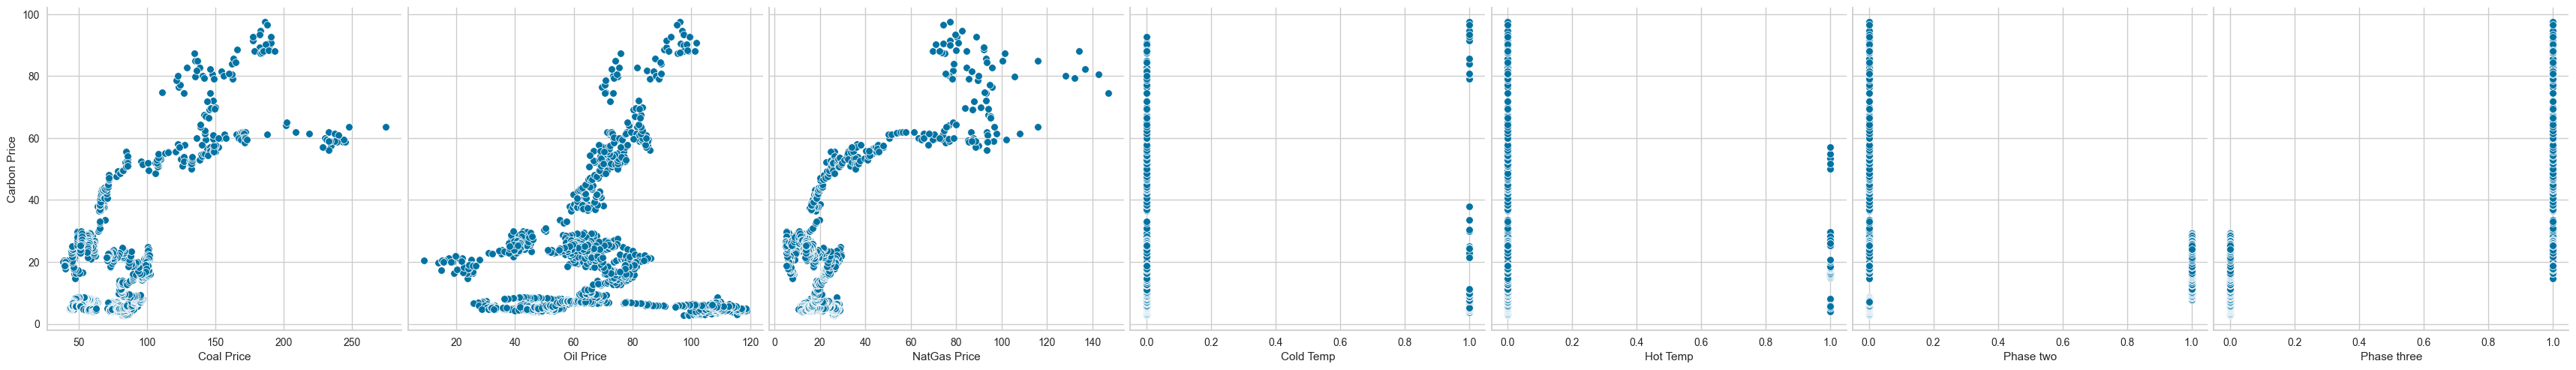

In [1632]:
fig = sns.pairplot(df, x_vars = ["Coal Price", "Oil Price",  "NatGas Price" ,"Cold Temp", "Hot Temp", "Phase two", "Phase three"], y_vars = "Carbon Price", height = 5)
fig.savefig("out.png") 

In [1633]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [1634]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
y_pred = linear_regression.predict(X_test)

In [1635]:
intercept = linear_regression.intercept_
#intercept = pd.DataFrame({"Coefficent":[intercept]})
intercept

-2.9805424951260946

In [1636]:
coeff_parameter = pd.DataFrame(linear_regression.coef_,X.columns,columns=['Coefficient'])
coeff_parameter.loc["Intercept"] = intercept
coeff_parameter


,Coefficient
Coal Price,0.000797
Oil Price,-0.020563
NatGas Price,0.525517
Cold Temp,-0.746974
Hot Temp,1.742612
Phase two,14.676928
Phase three,30.732139
Intercept,-2.980542


In [1637]:
print('mean_squared_error : ', mean_squared_error(y_test, y_pred))
print('mean_absolute_error : ', mean_absolute_error(y_test, y_pred))
print("root_mean_squared_error: ", np.sqrt(mean_squared_error(y_test,y_pred)))
print("R^2: " ,r2_score(y_test, y_pred))
print("Adjusted R^2: " , 1 - ( 1-linear_regression.score(X, y) ) * ( len(y_pred) - 1 ) / ( len(y_pred) - X.shape[1] - 1 ))

mean_squared_error :  37.87402909067535
mean_absolute_error :  4.517812494865617
root_mean_squared_error:  6.154187931049502
R^2:  0.8859609935857452
Adjusted R^2:  0.8887343063141943


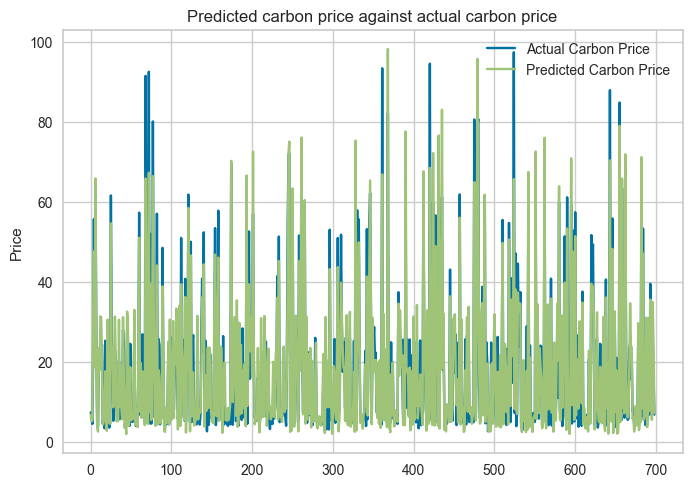

In [1638]:
plt.plot(y_test.array, label = 'Actual Carbon Price')
plt.plot(y_pred, label ='Predicted Carbon Price')
plt.legend()
plt.title("Predicted carbon price against actual carbon price")
plt.ylabel("Price")
plt.savefig("Model.png")
plt.show() 

In [1639]:
y_test = pd.DataFrame(y_test)
y_test.sort_index()


,Carbon Price
0,8.20
7,6.23
8,5.82
9,6.30
12,6.57
...,...
1729,91.61
1730,92.65
1731,94.65
1732,93.50


In [1640]:
index = y_test.index
index

Int64Index([ 384,  876,  190, 1379, 1630, 1307, 1649, 1279,  836,  657,
            ...
             649,  828, 1378,  351, 1502, 1137,  485, 1479, 1015,  177],
           dtype='int64', length=699)

In [1641]:
y_pred = pd.DataFrame(y_pred)
y_pred["Index"] = index
y_pred.set_index("Index", inplace = True)
y_pred.sort_index()

,0
Index,
0,9.150299
7,8.568912
8,8.846405
9,8.943651
12,8.543462
...,...
1729,65.915194
1730,67.392521
1731,68.593848


In [1642]:
y_pred["Carbon Price"] = y_pred[y_pred.columns[0]]

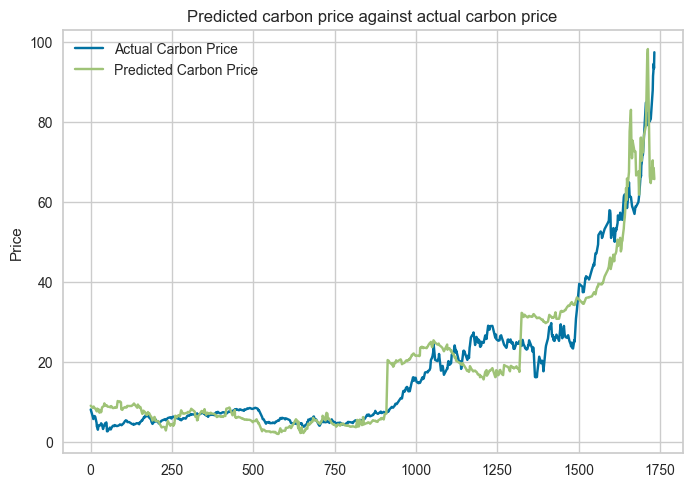

In [1643]:
plt.plot(y_test["Carbon Price"].sort_index(), label = 'Actual Carbon Price')
plt.plot(y_pred["Carbon Price"].sort_index(), label ='Predicted Carbon Price')
plt.title("Predicted carbon price against actual carbon price")
plt.ylabel("Price")
plt.legend()
plt.savefig("FullModel.png")
plt.show() 

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


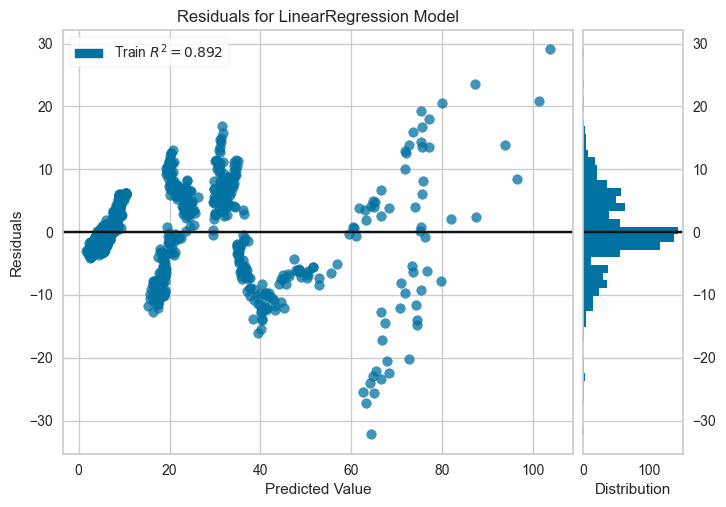

YellowbrickAttributeError: neither visualizer 'ResidualsPlot' nor wrapped estimator 'LinearRegression' have attribute 'line_color'

YellowbrickAttributeError: neither visualizer 'ResidualsPlot' nor wrapped estimator 'LinearRegression' have attribute 'line_color'

YellowbrickAttributeError: neither visualizer 'ResidualsPlot' nor wrapped estimator 'LinearRegression' have attribute 'line_color'

In [1644]:
visualizer = ResidualsPlot(linear_regression)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
#visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

visualizer